# Stock Price Prediction using FFT

## Project Overview
This Jupyter notebook explores the use of Fast Fourier Transform (FFT) to predict stock prices. The approach leverages historical stock price data, aiming to identify patterns and predict future values using both least squares approximation and FFT-based interpolation.

## Objectives
- Fetch historical stock price data.
- Apply FFT to analyze the stock price fluctuations.
- Develop a model to predict future stock prices.
- Evaluate the model using Root Mean Square Error (RMSE).

## Setup and Data Import

In this section, we import necessary libraries and fetch historical stock data using the `yfinance` API. The libraries include:
- `numpy` for numerical operations.
- `matplotlib.pyplot` for plotting graphs.
- `scipy.fftpack` for performing FFT.
- `yfinance` for downloading historical stock data.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack
from scipy.fftpack import dct, idct
import yfinance as yf

In [3]:
# Fetching stockprice data

# Goldman Sachs stock data from the last 13 years
gs = yf.download("GS", start="2011-01-01", end="2024-05-01")

# # data for Apple and Amazon to test out other results (need to adjust the train and test data accordingly)
# aapl = yf.download("AAPL", start="2011-01-01", end="2024-05-01")
# amzn = yf.download("AMZN", start="2011-01-01", end="2024-05-01")



[*********************100%%**********************]  1 of 1 completed


## Data Preparation

Here, we split the fetched data into training and test datasets. This is crucial for validating the performance of our predictive model later on.

In [5]:
# Splitting into test and train data

close_prices = gs['Close'].values
test_size = 150
train_size = len(close_prices) - test_size

## Fourier Transform Modelling 

Here, we model and predict the stock prices usin thre Fast Fourier Transform and Regression. The combination of least squares and FFT interpolation offers a comprehensive model for our predictions.

### What is the process and how do we use the Fourier Transform? 
1. To establish a baseline for our predictions, we apply a polynomial least squares approximation to the training data. This model will help in identifying the general trend of the stock prices over time.
2. Next we apply the Fourier Transform to the residuals, this converts the time series data into data in the frequency domain, which makes it much easier to perform a regression
3. We see which frequencies are dominant 
4. We make predictions in the frequency domain
5. We then interpolate and manually reconstruct the inverse Discrete FT of the predicted residuals
6. Finally, we evaluate our model's performance using the RMSE metric on the test dataset.

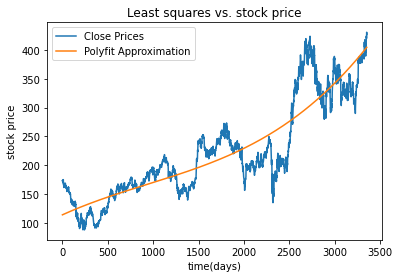

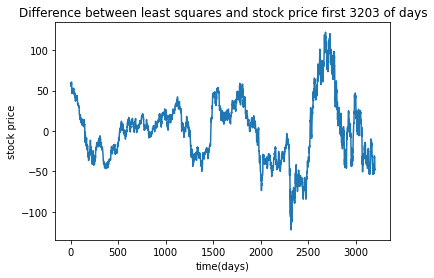

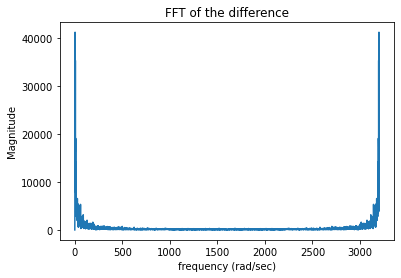

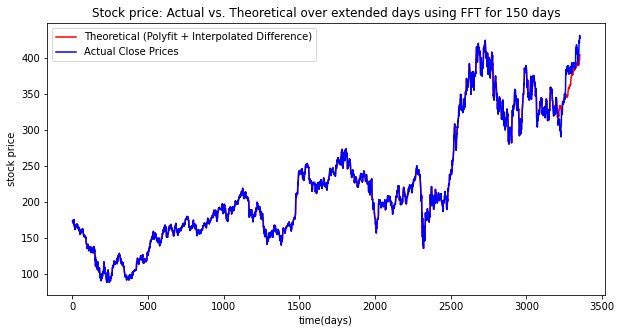


Root Mean Square Error (RMSE) for the test dataset: 19.773991498446915


In [6]:
# Predicting stock prices using the Fast Fourier Transform (Fourier Model)

def fourier_model(transform_name):
    x = np.arange(1, train_size + 1)
    p1 = np.polyfit(x, close_prices[:train_size], 3)
    xx = np.arange(1, len(close_prices) + 1)
    pp1 = np.polyval(p1, xx)

    plt.figure()
    plt.plot(xx, close_prices, label='Close Prices')
    plt.plot(xx, pp1, label='Polyfit Approximation')
    plt.xlabel('time(days)')
    plt.ylabel('stock price')
    plt.title('Least squares vs. stock price')
#     plt.title('Stock Price AAPL')
    plt.legend()
    plt.show()

    # Difference between actual data and trend- residuals (noise/volatilty)
    diff = close_prices[:train_size] - pp1[:train_size]

    # Plot the difference
    plt.figure()
    plt.plot(x, diff)
    plt.xlabel('time(days)')
    plt.ylabel('stock price')
    plt.title(f'Difference between least squares and stock price first {train_size} of days')
    plt.show()

    print()

    # FFT of the difference
    Y = fftpack.fft(diff)
    plt.figure()
    plt.plot(np.abs(Y))
    plt.xlabel('frequency (rad/sec)')
    plt.ylabel('Magnitude')
    plt.title(f'{transform_name} of the difference')
    plt.show()

    print()


    # IFT of the difference
    a = np.real(Y)
    b = -np.imag(Y)
    YY = np.zeros(len(xx))

    # Make sure `a` and `b` have the same size as the input `diff`
    omk = 2 * np.pi * np.arange(train_size) / train_size

    # Interpolate the difference for the last portion of the data
    for n in range(train_size, len(xx)):
      angle = omk * (n - train_size)
      YY[n] = np.sum(a * np.cos(angle) + b * np.sin(angle))
      YY[n] = -YY[n] / train_size

    # Use original difference for the first part
    YY[:train_size] = diff

    # Calculate the total price of stock from the least squares curve and interpolated differences
    tot = pp1 + YY

    # Plotting the actual stock price and the theoretical curve
    plt.figure(figsize=(10, 5))
    plt.plot(xx, tot, 'r', label='Theoretical (Polyfit + Interpolated Difference)')
    plt.plot(xx, np.concatenate([close_prices, np.full(len(xx) - len(close_prices), np.nan)]), 'b', label='Actual Close Prices')
    plt.xlabel('time(days)')
    plt.ylabel('stock price')
    plt.title(f'Stock price: Actual vs. Theoretical over extended days using {transform_name} for {test_size} days')
    plt.legend()
    plt.show()

    print()

    # Calculate RMSE for the test set
    test_start_index = train_size  # start of test data
    test_end_index = len(close_prices)  # end of test data

    # Extract the segment of the theoretical predictions that corresponds to the test period
    predicted_prices = tot[test_start_index:test_end_index]

    # Extract the actual prices in the test period
    actual_prices = close_prices[test_start_index:test_end_index]

    # Calculate the squared differences and then the mean
    mse = np.mean((actual_prices - predicted_prices) ** 2)

    # Take the square root of the mean squared error to get RMSE
    rmse = np.sqrt(mse)

    print("Root Mean Square Error (RMSE) for the test dataset:", rmse)


fourier_model("FFT")

## Summary of Findings 

We can see from the RMSE of 19.77 that that prediction was quite accurate, especially for such a simplistic process that only involved basic regression. This comes from the power of the Fourier Transform where analysis is a lot easier in the frequency domain. 
Moreover, the complexity of the FFT (Fast Fourier Transform) is $O(n \log n)$ which makes it an efficient method for doing lots of complicated calculation. Therefore, the Fast Fourier Transform is also particularly useful when predicting more volatile stocks and also complex option prices in some cases (with some modifcations).

## Predicting stock prices using the Fourier Cosine Transform

We now look at whether the Fourier Cosine Transform performs better. The rationale here is that the Fourier Cosine Transform can be better at analysing the the details in the frequency domain. Therefore, it might work better in a case wirh such fluctuations. It, however, gives less importance to the high frequency trends, as that is handled by the sine component, which may be a drawback. 

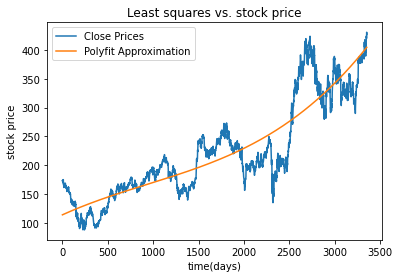

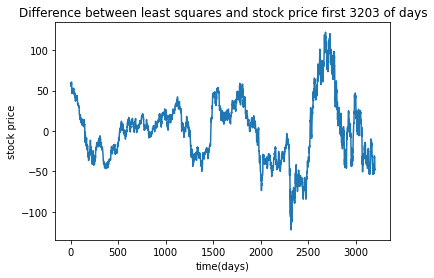

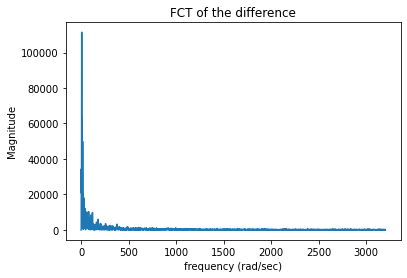

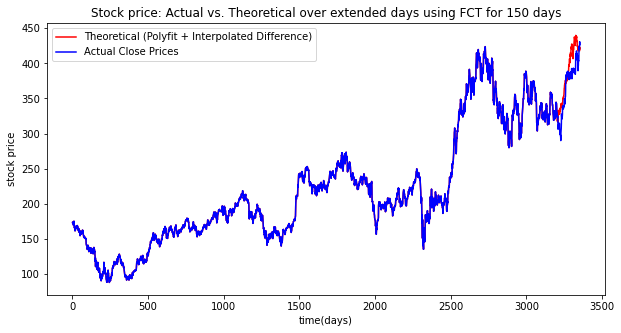


Root Mean Square Error (RMSE) for the test dataset: 25.07646249746253


In [7]:
# Predicting stock prices using the Fast Fourier Transform (Fourier Cosine transform model)

def cosine_model(transform_name):
    x = np.arange(1, train_size + 1)
    p1 = np.polyfit(x, close_prices[:train_size], 3)
    xx = np.arange(1, len(close_prices) + 1)
    pp1 = np.polyval(p1, xx)

    plt.figure()
    plt.plot(xx, close_prices, label='Close Prices')
    plt.plot(xx, pp1, label='Polyfit Approximation')
    plt.xlabel('time(days)')
    plt.ylabel('stock price')
    plt.title('Least squares vs. stock price')
    plt.legend()
    plt.show()

    # Difference between actual data and trend
    diff = close_prices[:train_size] - pp1[:train_size]

    # Plot the difference
    plt.figure()
    plt.plot(x, diff)
    plt.xlabel('time(days)')
    plt.ylabel('stock price')
    plt.title(f'Difference between least squares and stock price first {train_size} of days')
    plt.show()

    print()

    # FFT of the difference
    Y = dct(diff, type=2)
    plt.figure()
    plt.plot(np.abs(Y))
    plt.xlabel('frequency (rad/sec)')
    plt.ylabel('Magnitude')
    plt.title(f'{transform_name} of the difference')
    plt.show()

    print()


    # FFT of the difference
    a = np.real(Y)
    b = -np.imag(Y)
    YY = np.zeros(len(xx))

    # Make sure `a` and `b` have the same size as the input `diff`
    omk = 2 * np.pi * np.arange(train_size) / train_size

    # Interpolate the difference for the last portion of the data
    for n in range(train_size, len(xx)):
      angle = omk * (n - train_size)
      YY[n] = np.sum(a * np.cos(angle) + b * np.sin(angle))
      YY[n] = -YY[n] / train_size

    # Use original difference for the first part
    YY[:train_size] = diff

    # Calculate the total price of stock from the least squares curve and interpolated differences
    tot = pp1 + YY

    # Plotting the actual stock price and the theoretical curve
    plt.figure(figsize=(10, 5))
    plt.plot(xx, tot, 'r', label='Theoretical (Polyfit + Interpolated Difference)')
    plt.plot(xx, np.concatenate([close_prices, np.full(len(xx) - len(close_prices), np.nan)]), 'b', label='Actual Close Prices')
    plt.xlabel('time(days)')
    plt.ylabel('stock price')
    plt.title(f'Stock price: Actual vs. Theoretical over extended days using {transform_name} for {test_size} days')
    plt.legend()
    plt.show()

    print()

    # Calculate RMSE for the test set
    test_start_index = train_size  # start of test data
    test_end_index = len(close_prices)  # end of test data

    # Extract the segment of the theoretical predictions that corresponds to the test period
    predicted_prices = tot[test_start_index:test_end_index]

    # Extract the actual prices in the test period
    actual_prices = close_prices[test_start_index:test_end_index]

    # Calculate the squared differences and then the mean
    mse = np.mean((actual_prices - predicted_prices) ** 2)

    # Take the square root of the mean squared error to get RMSE
    rmse = np.sqrt(mse)

    print("Root Mean Square Error (RMSE) for the test dataset:", rmse)


cosine_model("FCT")


## Summary of Findings

As we can see here the RMSE is slightly higher than when we interpolated using the fourier transform. This is likely because not all the trends are captured by the regression, while the cosine component captures all the details. 

## Predicting stock prices using the Fourier Sine Transform

We now look at whether the Fourier Sine Transform performs better. The rationale here is that the Fourier Sine Transform can be better at analysing the high frequency signals and hence in some cases it may perform better. It generally misses out the minute fluctuations though, as that is handled by the cosine component, which may be a drawback. 

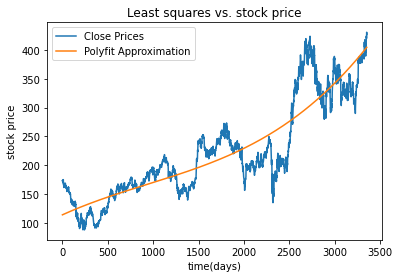

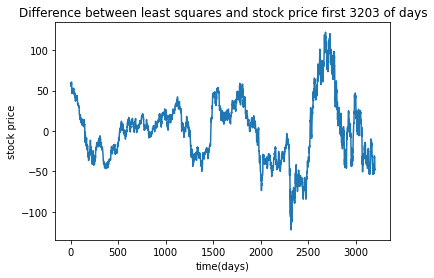

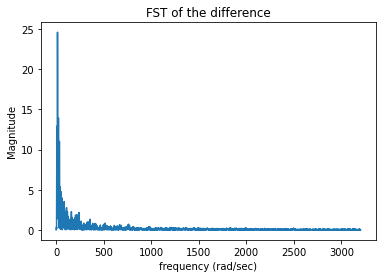

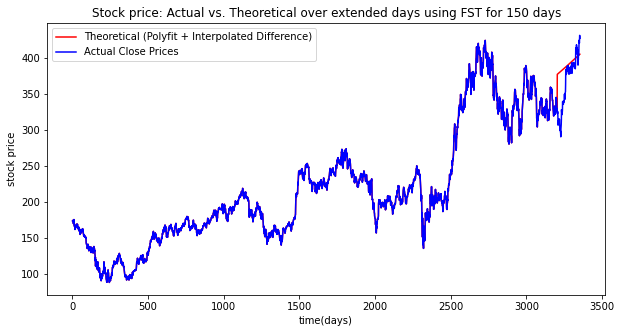


Root Mean Square Error (RMSE) for the test dataset: 37.605213644035224


In [8]:
# Predicting stock prices using the Fast Fourier Transform (Fourier Cosine transform model)

def dst(x):
  """
  Performs a discrete sine transform (DST) on a signal `x`.

  Args:
    x: The input signal as a numpy array.

  Returns:
    The discrete sine transform of `x` as a numpy array.
  """
  N = len(x)
  y = dct(np.append(x, np.zeros(N)), type=2, norm='ortho')[:N]
  return np.sqrt(2.0 / N) * y



def sine_model(transform_name):
    x = np.arange(1, train_size + 1)
    p1 = np.polyfit(x, close_prices[:train_size], 3)
    xx = np.arange(1, len(close_prices) + 1)
    pp1 = np.polyval(p1, xx)

    plt.figure()
    plt.plot(xx, close_prices, label='Close Prices')
    plt.plot(xx, pp1, label='Polyfit Approximation')
    plt.xlabel('time(days)')
    plt.ylabel('stock price')
    plt.title('Least squares vs. stock price')
    plt.legend()
    plt.show()

    # Difference between actual data and trend
    diff = close_prices[:train_size] - pp1[:train_size]

    # Plot the difference
    plt.figure()
    plt.plot(x, diff)
    plt.xlabel('time(days)')
    plt.ylabel('stock price')
    plt.title(f'Difference between least squares and stock price first {train_size} of days')
    plt.show()

    print()

    # FFT of the difference
    Y = dst(diff)
    plt.figure()
    plt.plot(np.abs(Y))
    plt.xlabel('frequency (rad/sec)')
    plt.ylabel('Magnitude')
    plt.title(f'{transform_name} of the difference')
    plt.show()

    print()


    # FFT of the difference
    a = np.real(Y)
    b = -np.imag(Y)
    YY = np.zeros(len(xx))

    # Make sure `a` and `b` have the same size as the input `diff`
    omk = 2 * np.pi * np.arange(train_size) / train_size

    # Interpolate the difference for the last portion of the data
    for n in range(train_size, len(xx)):
      angle = omk * (n - train_size)
      YY[n] = np.sum(a * np.cos(angle) + b * np.sin(angle))
      YY[n] = -YY[n] / train_size

    # Use original difference for the first part
    YY[:train_size] = diff

    # Calculate the total price of stock from the least squares curve and interpolated differences
    tot = pp1 + YY

    # Plotting the actual stock price and the theoretical curve
    plt.figure(figsize=(10, 5))
    plt.plot(xx, tot, 'r', label='Theoretical (Polyfit + Interpolated Difference)')
    plt.plot(xx, np.concatenate([close_prices, np.full(len(xx) - len(close_prices), np.nan)]), 'b', label='Actual Close Prices')
    plt.xlabel('time(days)')
    plt.ylabel('stock price')
    plt.title(f'Stock price: Actual vs. Theoretical over extended days using {transform_name} for {test_size} days')
    plt.legend()
    plt.show()

    print()

    # Calculate RMSE for the test set
    test_start_index = train_size  # start of test data
    test_end_index = len(close_prices)  # end of test data

    # Extract the segment of the theoretical predictions that corresponds to the test period
    predicted_prices = tot[test_start_index:test_end_index]

    # Extract the actual prices in the test period
    actual_prices = close_prices[test_start_index:test_end_index]

    # Calculate the squared differences and then the mean
    mse = np.mean((actual_prices - predicted_prices) ** 2)

    # Take the square root of the mean squared error to get RMSE
    rmse = np.sqrt(mse)

    print("Root Mean Square Error (RMSE) for the test dataset:", rmse)


sine_model("FST")

## Predicting stock prices using the Fourier Sine Transform

As we can see here, the RMSE is significantly higher, nearly double the RMSE we got when using the fourier transform. This is because in stock prices like these the details and fluctuations are very important.  

# Conclusion 

This is a very simple example to illustrate how well the Fourier Transform works when analysig volatile and fluctuating signals like stocks. Moreover, the fact that we are using the Fast Fourier Transform which is time efficient is very useful when dealing with rapidly changing stock prices. 

Most of the use of the Fourier Transform today however is used when predicting option prices. This is done by famous companies like JP Morgan. OIptions prices, particularly Asian option prices, are more complicated PDEs that can be simplified by converting into frequency domains as this Fast Fourier Transform does. 